In [5]:
# General and Data Handling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils import shuffle

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from IPython.display import display, clear_output

# PyTorch and Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import timm

# Metrics and Evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Geometric Learning and Transformations
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA
from geomstats.geometry.hypersphere import Hypersphere

# DeepInsight and Feature Selection
from pyDeepInsight import ImageTransformer, CAMFeatureSelector

# Optimization
import optuna

# Warnings
import warnings

warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('ibd_data_set.csv',index_col=0)
data.head()

,OTU.1,OTU.2,OTU.3,OTU.4,OTU.5,OTU.6,OTU.7,OTU.8,OTU.9,OTU.10,...,OTU.36340,OTU.36341,OTU.36342,OTU.36343,OTU.36344,OTU.36345,OTU.36346,OTU.36347,OTU.36348,OTU.36349
099A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
062B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
166A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = data.div(data.sum(axis=1), axis=0) #Convert the data into compositional data through division by the total sum.
data = np.sqrt(data) #Apply a square-root transformation to the data to map it into directional space.
X=data.values
sample=pd.read_csv('ibd_response.csv',index_col=0)
y=sample['ibd']
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = np.unique(y_enc).size

In [6]:
pixel_size = (224, 224)
sphere = Hypersphere(dim=36348)  #Define a hypersphere in a space with one fewer dimension than the original data to facilitate Tangent PCA.
it = ImageTransformer(
    feature_extractor=TangentPCA(sphere, n_components=2),
    pixels=pixel_size) #Apply the top 2 Principal Geodesic Analysis (PGA) components for dimensionality reduction to map them to their corresponding pixels.

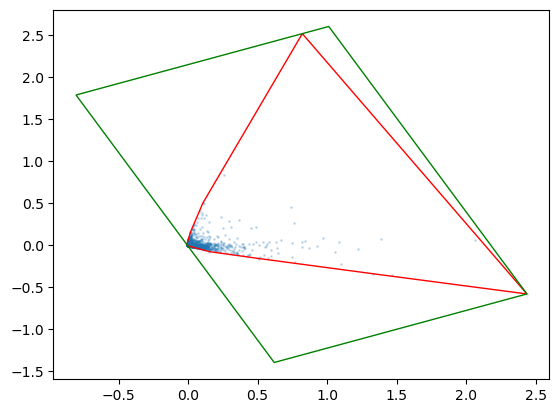

In [11]:
it.fit(X, y=y, plot=True) #Corresponding Pixels image
X_img=it.transform(X)

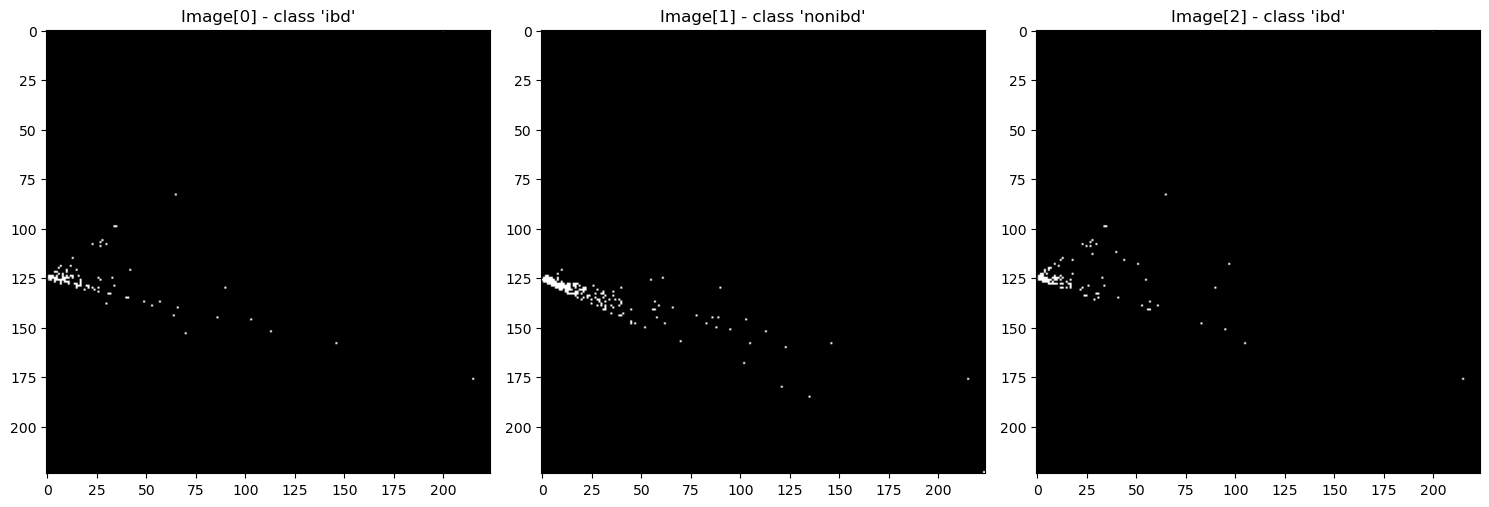

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_img[i]*10000) #Multiply the data for visualization purposes, which is an unnecessary step for actual training.
    ax[i].title.set_text(f"Image[{i}] - class '{y[i]}'")
plt.tight_layout()

It is possible to observe that each image has a different shape. This occurs because the actual values of the corresponding pixels are zero, making them indistinguishable from the background. To address this, we add a very small value to ensure that all corresponding pixels have non-zero values, thereby aligning the shapes of the images.

In [18]:
fdm = it.feature_density_matrix()
fdm_nonzero_indices = np.nonzero(fdm)
X_img_shape = it.transform(X)
epsilon = 1e-8
for i in range(len(X_img_shape)):
    for channel in range(3):
        X_img_shape[i][fdm_nonzero_indices[0], fdm_nonzero_indices[1], channel] += epsilon

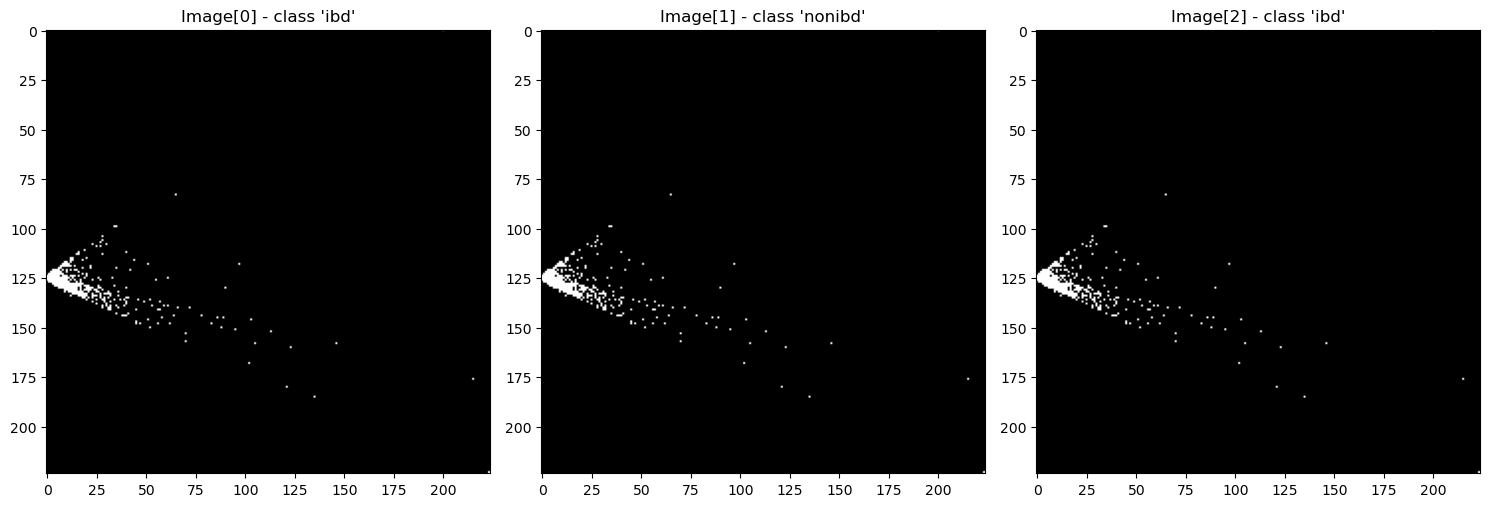

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_img_shape[i]*100000000) #Multiply the data for visualization purposes, which is an unnecessary step for actual training.
    ax[i].title.set_text(f"Image[{i}] - class '{y[i]}'")
plt.tight_layout()

We can confirm that the shapes of all images have been standardized.

### Total code with Optuna and CNNs

In [23]:
# Apply 10-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True)

# Lists to store accuracy and AUC
accuracies = []
aucs = []

le = LabelEncoder()  # Label encoder

pixel_size = (224, 224)
sphere = Hypersphere(dim=36348)  # Declare a hypersphere with one dimension lower than the actual dimension for Tangent PCA
it = ImageTransformer(
    feature_extractor=TangentPCA(sphere, n_components=2),
    pixels=pixel_size)  # The default center point for TangentPCA is the Frechet mean

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Define a trial function for Optuna to optimize lr and weight_decay
def optimize_trial(trial):
    # Set learning rate and weight_decay as hyperparameters to optimize using Optuna
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    
    actual_labels_list = []
    probs_list = []
    
    for train_index, test_index in kf.split(X):
        # Train/Test Split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Apply ImageTransformer (with exception handling)
        try:
            it.fit(X_train, y=y_train, plot=False)
        except Exception as e:
            print(f"SVD convergence issue: {e}. Continuing...")
            continue  # Skip to the next iteration if convergence fails

        X_train_img = it.transform(X_train)
        X_test_img = it.transform(X_test)

        fdm = it.feature_density_matrix()
        fdm_nonzero_indices = np.nonzero(fdm)
        X_train_img = it.transform(X_train)
        X_test_img = it.transform(X_test)
        epsilon = 1e-8
        for i in range(len(X_train_img)):
            for channel in range(3):
                X_train_img[i][fdm_nonzero_indices[0], fdm_nonzero_indices[1], channel] += epsilon

        preprocess = transforms.Compose([
            transforms.ToTensor()
        ])

        # Convert to Tensor
        X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float()
        y_train_tensor = torch.from_numpy(le.fit_transform(y_train))

        X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float()
        y_test_tensor = torch.from_numpy(le.transform(y_test))

        # Set up DataLoader
        batch_size = 32
        trainset = TensorDataset(X_train_tensor, y_train_tensor)
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

        testset = TensorDataset(X_test_tensor, y_test_tensor)
        testloader = DataLoader(testset, batch_size=1, shuffle=False)

        # Load EfficientNet B0 model and modify it for binary classification
        # model = models.efficientnet_b0(weights='DEFAULT')
        # Modify the last fully connected layer for binary classification
        # num_ftrs = model.classifier[1].in_features
        # model.classifier[1] = nn.Linear(num_ftrs, 1)  # Output layer for binary classification
        model = models.resnet50(weights='DEFAULT')
        
        # Modify the last fully connected layer for binary classification
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 1)  # Output layer for binary classification
        
        # Define loss function and optimizer
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Move model to GPU
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        # Start training
        epochs = 3  # Set a small number of epochs for optimization search
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0

            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
        
        # Switch to evaluation mode
        model.eval()

        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                outputs = model(inputs)
                probs = torch.sigmoid(outputs).cpu().numpy()

                # Store actual labels and probabilities for AUC calculation
                actual_labels_list.append(labels.cpu().numpy()[0])
                probs_list.append(probs[0])

    # Calculate AUC
    try:
        auc = roc_auc_score(actual_labels_list, probs_list)
    except ValueError:
        # Handle exceptions if AUC calculation fails
        print("Failed to calculate AUC.")
        auc = 0.0

    # Optuna aims to maximize the objective function, so return AUC
    return auc

# Run Optuna optimization
study.optimize(optimize_trial, n_trials=5)

# Print optimization results
print(f'Best trial AUC: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

[I 2025-02-04 12:55:36,075] A new study created in memory with name: no-name-7e6f12d4-2e1f-4f04-9b08-340d829fdb1e


SVD convergence issue: SVD did not converge. Continuing...


[I 2025-02-04 12:56:45,244] Trial 0 finished with value: 0.5987509758001561 and parameters: {'lr': 0.0023830559018604516, 'weight_decay': 0.0006831976458430422}. Best is trial 0 with value: 0.5987509758001561.


SVD convergence issue: SVD did not converge. Continuing...


[I 2025-02-04 12:57:58,421] Trial 1 finished with value: 0.47826086956521735 and parameters: {'lr': 0.0006313150544351636, 'weight_decay': 1.8425323089122014e-06}. Best is trial 0 with value: 0.5987509758001561.


SVD convergence issue: SVD did not converge. Continuing...


[I 2025-02-04 12:59:06,139] Trial 2 finished with value: 0.5659640905542545 and parameters: {'lr': 0.0010256532521941797, 'weight_decay': 1.4232322716588077e-05}. Best is trial 0 with value: 0.5987509758001561.


SVD convergence issue: SVD did not converge. Continuing...


[I 2025-02-04 13:00:17,828] Trial 3 finished with value: 0.6272727272727272 and parameters: {'lr': 1.8432801265922758e-05, 'weight_decay': 3.503815117988807e-05}. Best is trial 3 with value: 0.6272727272727272.


SVD convergence issue: SVD did not converge. Continuing...


[I 2025-02-04 13:01:31,216] Trial 4 finished with value: 0.6314516129032258 and parameters: {'lr': 0.00013053037392438596, 'weight_decay': 0.0036483544039990056}. Best is trial 4 with value: 0.6314516129032258.


Best trial AUC: 0.6314516129032258
Best hyperparameters: {'lr': 0.00013053037392438596, 'weight_decay': 0.0036483544039990056}
